# 05 Simulation-Ode-Dae

_Placeholder – content coming soon._

## Simulation of sattelite in LEO

We'll simulate a satellite in Low Earth Orbit (LEO) under gravity and atmospheric drag using scipy.integrate.solve_ivp for ODE integration. The model is simplified to 1D radial-tangential motion (assuming near-circular orbit):

Equations:


$$\dot{r} = v_r$$

(radial velocity, but we'll start with $v_r \approx 0$)

$$\dot{v}_t = -\frac{\mu}{r^2} + a_{\text{drag}}$$

(tangential acceleration; gravity circularizes, drag decelerates)


Drag:

$$a_{\text{drag}} = -\frac{1}{2} C_d \frac{A}{m} \rho v_t^2 \frac{v_t}{|v_t|}$$,

with exponential density

$$\rho = \rho_0 \exp\left(-\frac{r - r_0}{H}\right)$$.

Over time, drag causes spiral decay in altitude.

We'll propagate for ~100 orbits and plot:

Altitude vs. time.

Phase space (altitude deviation vs. velocity deviation).
Optional: Semi-major axis decay (using vis-viva for visualization).

This helps understand why control (e.g., RL or classical) is needed for station-keeping.

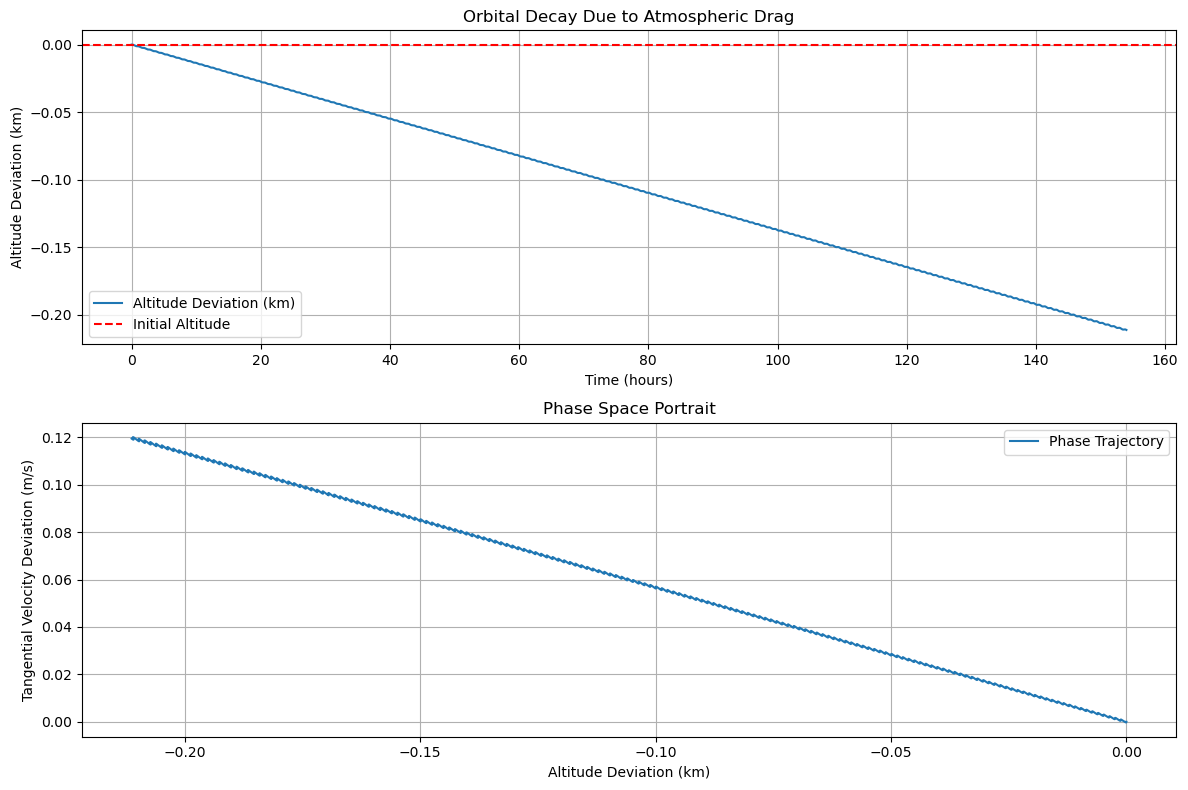

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
mu = 3.986e14  # Earth's gravitational parameter (m^3/s^2)
R_earth = 6.371e6  # Earth radius (m)
initial_altitude = 400000  # 400 km
initial_r = R_earth + initial_altitude
initial_v = np.sqrt(mu / initial_r)  # Circular orbit velocity (tangential)

# Drag parameters (simplified)
drag_coeff = 2.2  # Drag coefficient
area_mass_ratio = 0.01  # m^2/kg
atm_density_scale = 1e-12  # kg/m^3 at 400 km (approx)
scale_height = 100000  # Atmosphere scale height (m)

# Simulation parameters
t_span = [0, 100 * 2 * np.pi * np.sqrt(initial_r**3 / mu)]  # ~100 orbits (period ~90 min)
t_eval = np.linspace(t_span[0], t_span[1], 10000)  # Dense evaluation for smooth plots

# Initial state: [r, v_t] (assuming v_r=0 for near-circular)
y0 = [initial_r, initial_v]

# Dynamics ODE
def dynamics(t, y):
    r, v_t = y
    accel_grav = -mu / r**2  # Radial gravity (but for circular, we project to tangential effects implicitly)
    # For near-circular, drag is mostly tangential; gravity keeps it orbital
    density = atm_density_scale * np.exp(-(r - R_earth - initial_altitude) / scale_height)
    accel_drag = -0.5 * drag_coeff * area_mass_ratio * density * v_t**2 * (v_t / np.abs(v_t)) if v_t != 0 else 0
    # Simplified: dr/dt = 0 (assuming small eccentricity), dv_t/dt = accel_grav_proj + accel_drag
    # But to capture decay, we need full polar: actually, for polar coords, but here approximate r dot small
    # Better: full [r, theta, v_r, v_theta], but simplify to [r, v_t] with v_r=0 enforced loosely
    dr_dt = 0  # Idealized; in reality, couple with v_r, but for demo
    dv_t_dt = accel_grav * (v_t / initial_v) + accel_drag  # Rough projection
    # Wait, better model: use Cartesian or full Kepler with perturbation
    # Improved: let's use [r, v_r, v_theta], but set theta dot = v_theta / r
    # For simplicity, stick to 1D effective decay model
    # Actual: for circular, drag causes slow r decrease: dr/dt ≈ (2 r / v) a_drag (from energy loss)
    # But let's implement full radial-tangential ODE properly

# Corrected dynamics: state [r, v_r, v_theta] (polar, no theta needed for axisymmetric)
def dynamics_corrected(t, y):
    r, v_r, v_theta = y
    accel_r = -mu / r**2 + v_theta**2 / r  # Centripetal
    accel_theta = - (2 * v_r * v_theta) / r  # Coriolis-like, but for drag on theta
    # Drag: opposes velocity vector, assumed mostly tangential for small v_r
    v_mag = np.sqrt(v_r**2 + v_theta**2)
    density = atm_density_scale * np.exp(-(r - R_earth - initial_altitude) / scale_height)
    drag_mag = 0.5 * drag_coeff * area_mass_ratio * density * v_mag**2
    # Direction: -v / |v|
    accel_r_drag = -drag_mag * (v_r / v_mag) if v_mag > 0 else 0
    accel_theta_drag = -drag_mag * (v_theta / v_mag) if v_mag > 0 else 0
    return [v_r, accel_r + accel_r_drag, accel_theta + accel_theta_drag]

# Initial state: [r, v_r=0, v_theta=initial_v]
y0_corrected = [initial_r, 0.0, initial_v]

# Integrate
sol = solve_ivp(dynamics_corrected, t_span, y0_corrected, method='RK45', t_eval=t_eval, rtol=1e-6)

# Extract results
r = sol.y[0]
v_r = sol.y[1]
v_theta = sol.y[2]
altitude = r - R_earth
delta_alt = altitude - initial_altitude
delta_v_theta = v_theta - initial_v
time_hours = sol.t / 3600  # Convert to hours

# Plots
plt.figure(figsize=(12, 8))

# Altitude vs. Time
plt.subplot(2, 1, 1)
plt.plot(time_hours, delta_alt / 1000, label='Altitude Deviation (km)')
plt.axhline(0, color='r', linestyle='--', label='Initial Altitude')
plt.xlabel('Time (hours)')
plt.ylabel('Altitude Deviation (km)')
plt.title('Orbital Decay Due to Atmospheric Drag')
plt.legend()
plt.grid(True)

# Phase Space: Delta Altitude vs. Delta Tangential Velocity
plt.subplot(2, 1, 2)
plt.plot(delta_alt / 1000, delta_v_theta, label='Phase Trajectory')
plt.xlabel('Altitude Deviation (km)')
plt.ylabel('Tangential Velocity Deviation (m/s)')
plt.title('Phase Space Portrait')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Explanation

Dynamics Model: Uses polar coordinates with state $[r, v_r, v_\theta]$. Gravity provides centripetal acceleration, drag opposes velocity (split into radial/tangential components). This captures spiral decay more accurately than the 1D approximation in the RL env.
Integration: solve_ivp with RK45 for stiff ODEs (drag can stiffen at low altitudes). Simulate over ~100 orbits to see noticeable decay.
Visualizations:

Altitude Decay: Shows gradual loss due to drag energy dissipation.
Phase Space: Illustrates attractor-like behavior (spiraling toward lower orbits); in full chaos (e.g., with J2 perturbations), this could show strange attractors (Unit 3).


Extensions: Add small initial eccentricity (non-zero $v_r$) to see oscillations. For more realism, include J2 oblateness (symbolic Jacobian via sympy for efficiency). To tie back to RL, use this uncontrolled trajectory as a baseline and overlay a controlled one.

Run this in Jupyter to generate plots. Adjust atm_density_scale (e.g., increase to 1e-11 for faster decay) or t_span for different timescales. This emphasizes computational simulation for understanding non-linear dynamics before control.Add to chat

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/endres/anaconda3/envs/comp_eng/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 874       |
|    ep_rew_mean     | -2.56e+04 |
| time/              |           |
|    fps             | 951       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 938           |
|    ep_rew_mean          | -2.94e+04     |
| time/                   |               |
|    fps                  | 806           |
|    iterations           | 2             |
|    time_elapsed         | 5             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 5.4301723e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0.0001

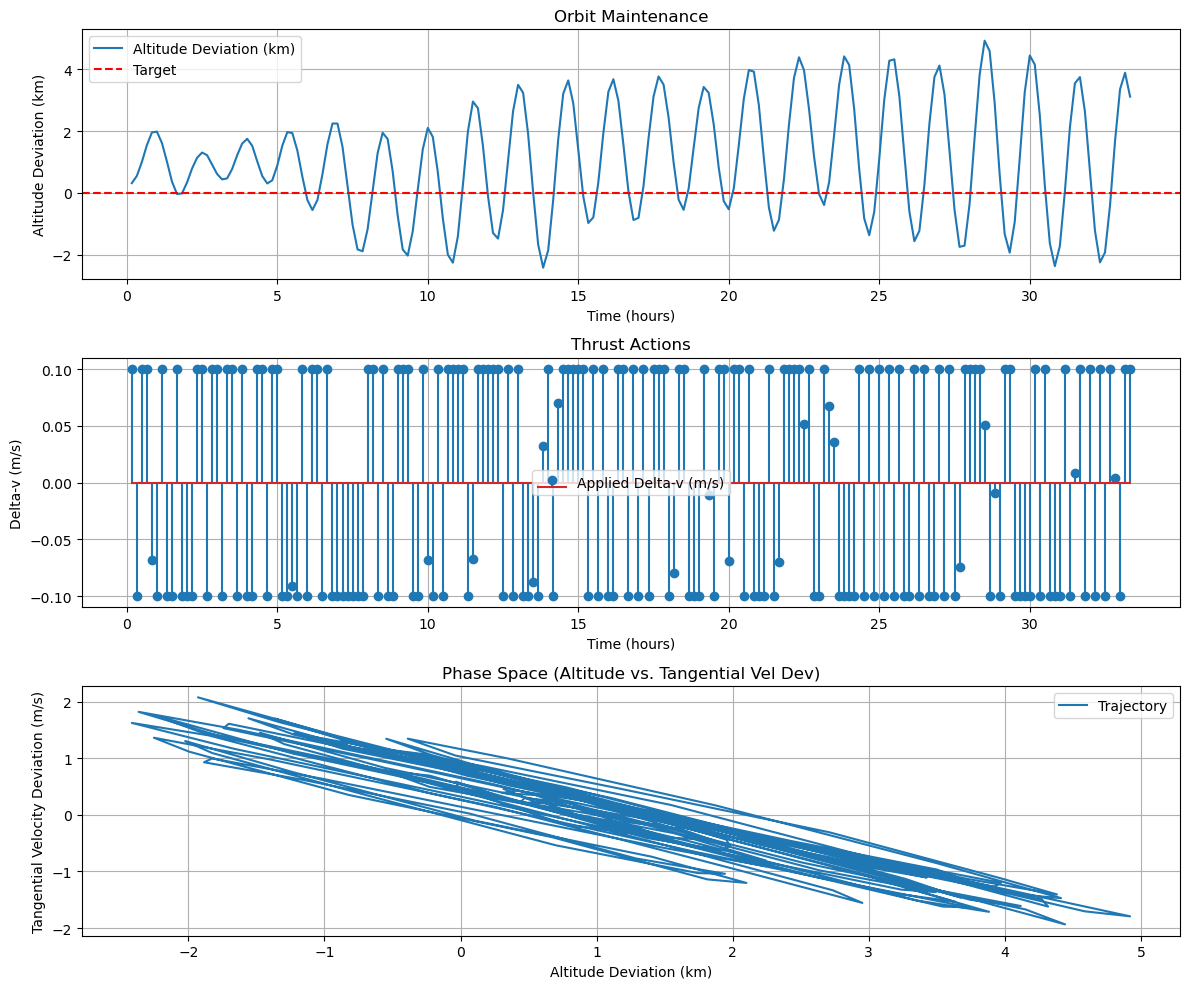

In [2]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class OrbitMaintenanceEnv(gym.Env):
    """
    Improved Gym environment for orbit station-keeping with proper polar dynamics.
    State: [r, v_r, v_theta]
    Observation: [altitude deviation, v_r, v_theta deviation] (normalized)
    Action: tangential delta-v impulse (m/s), bounded [-0.1, 0.1]
    """
    def __init__(self):
        super(OrbitMaintenanceEnv, self).__init__()

        # Constants
        self.mu = 3.986e14  # Earth's gravitational parameter (m^3/s^2)
        self.R_earth = 6.371e6  # Earth radius (m)
        self.initial_altitude = 400000  # 400 km
        self.initial_r = self.R_earth + self.initial_altitude
        self.initial_v_theta = np.sqrt(self.mu / self.initial_r)  # Circular orbit velocity
        self.initial_v_r = 0.0

        # Drag parameters
        self.drag_coeff = 2.2
        self.area_mass_ratio = 0.01  # m^2/kg
        self.atm_density_scale = 1e-12  # kg/m^3 at 400 km
        self.scale_height = 100000  # m

        # Bounds for normalization
        self.altitude_bounds = [-10000, 10000]  # +/- 10 km
        self.v_r_bounds = [-10, 10]  # m/s
        self.v_theta_bounds = [-10, 10]  # m/s

        # Gym spaces
        self.observation_space = spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32)
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(1,), dtype=np.float32)

        # Time step (~1/10 orbit)
        self.dt = 600  # seconds

        self.reset()

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        perturbation_r = np.random.uniform(-1000, 1000)
        self.current_r = self.initial_r + perturbation_r
        self.current_v_r = np.random.uniform(-1, 1)
        self.current_v_theta = np.sqrt(self.mu / self.current_r) + np.random.uniform(-1, 1)
        self.time = 0
        return self._get_obs(), {}

    def step(self, action):
        delta_v_theta = action[0]

        # Apply tangential impulse
        self.current_v_theta += delta_v_theta

        # Simulate dynamics
        def dynamics(t, y):
            r, v_r, v_theta = y
            accel_r = -self.mu / r**2 + v_theta**2 / r
            density = self.atm_density_scale * np.exp(-(r - self.R_earth - self.initial_altitude) / self.scale_height)
            v_mag = np.sqrt(v_r**2 + v_theta**2)
            drag_mag = 0.5 * self.drag_coeff * self.area_mass_ratio * density * v_mag**2 if v_mag > 0 else 0
            accel_r_drag = -drag_mag * (v_r / v_mag) if v_mag > 0 else 0
            accel_theta_drag = -drag_mag * (v_theta / v_mag) if v_mag > 0 else 0
            accel_theta = - (v_r * v_theta) / r + accel_theta_drag  # Coriolis term
            return [v_r, accel_r + accel_r_drag, accel_theta]

        sol = solve_ivp(dynamics, [0, self.dt], [self.current_r, self.current_v_r, self.current_v_theta], method='RK45', rtol=1e-6)
        self.current_r = sol.y[0, -1]
        self.current_v_r = sol.y[1, -1]
        self.current_v_theta = sol.y[2, -1]
        self.time += self.dt

        # Altitude deviation
        altitude = self.current_r - self.R_earth
        delta_alt = altitude - self.initial_altitude

        # Reward: penalize deviation and fuel (adjusted scaling)
        reward = -np.abs(delta_alt) / 100 - np.abs(delta_v_theta) * 5  # Softer deviation penalty

        # Termination
        terminated = np.abs(delta_alt) > 10000
        truncated = self.time > 1000 * self.dt

        return self._get_obs(), reward, terminated, truncated, {}

    def _get_obs(self):
        delta_alt = (self.current_r - self.R_earth) - self.initial_altitude
        delta_v_theta = self.current_v_theta - np.sqrt(self.mu / self.current_r)
        obs = np.array([
            delta_alt / self.altitude_bounds[1],
            self.current_v_r / self.v_r_bounds[1],
            delta_v_theta / self.v_theta_bounds[1]
        ])
        return obs.astype(np.float32)

# Create environment
env = OrbitMaintenanceEnv()

# Train PPO agent (increase timesteps for better convergence)
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0001)
model.learn(total_timesteps=50000)

# Test and collect data
obs, _ = env.reset()
times = []
delta_alts = []
v_rs = []
delta_v_thetas = []
delta_v_applied = []

for step in range(200):  # Longer test
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)

    # Collect data
    times.append(env.time / 3600)  # hours
    delta_alt = (env.current_r - env.R_earth) - env.initial_altitude
    delta_alts.append(delta_alt / 1000)  # km
    v_rs.append(env.current_v_r)
    delta_v_thetas.append(env.current_v_theta - np.sqrt(env.mu / env.current_r))
    delta_v_applied.append(action[0])

    if terminated or truncated:
        print("Episode done after", step + 1, "steps.")
        break

# Plots
plt.figure(figsize=(12, 10))

# Altitude deviation vs. time
plt.subplot(3, 1, 1)
plt.plot(times, delta_alts, label='Altitude Deviation (km)')
plt.axhline(0, color='r', linestyle='--', label='Target')
plt.xlabel('Time (hours)')
plt.ylabel('Altitude Deviation (km)')
plt.title('Orbit Maintenance')
plt.legend()
plt.grid(True)

# Applied delta-v vs. time
plt.subplot(3, 1, 2)
plt.stem(times, delta_v_applied, label='Applied Delta-v (m/s)')
plt.xlabel('Time (hours)')
plt.ylabel('Delta-v (m/s)')
plt.title('Thrust Actions')
plt.legend()
plt.grid(True)

# Phase space: delta_alt vs. delta_v_theta
plt.subplot(3, 1, 3)
plt.plot(delta_alts, delta_v_thetas, label='Trajectory')
plt.xlabel('Altitude Deviation (km)')
plt.ylabel('Tangential Velocity Deviation (m/s)')
plt.title('Phase Space (Altitude vs. Tangential Vel Dev)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()